# Relationship between Poisson and PDF likelihoods

In this notebook, we look at two possible likelihoods for describing sampled data, compare them and show why it might be quite okay to interchange them.

** Figures produced in this notebook appear in the MRP paper, section 3.3**

## Theoretical Discussion

Historically, Poisson-sampled data has typically been characterised by the likelihood

$$ \ln\mathcal{L}_1(\vec{\theta},m_{\rm min}) = -Aq(\vec{\theta}) + \sum_{i=1}^{N} \ln (Ag(m_i|\vec{\theta})), $$

where $q = \int g$. However, we could aso describe the likelihood simply as the log of the PDF of the distribution:

$$ \ln \mathcal{L}_2(\vec{\theta}_3,m_{\rm min}) = \sum_{i=1}^N \ln \frac{g}{q}, $$

but in this case the likelihood has no dependence on the normalisation, $A$.

So the question is, are these the same, similar, or different? How are they related?

First note that for $\mathcal{L}_2$, $A$ would typically be derived post-fit by equating the number (or number density) of haloes/variates with the integral of the distribution, i.e.

$$ A = A_N = \frac{N/V}{q}, $$

where $N$ is the number of haloes, and $V$ the volume (if applicable). Now, let us assume that we are maximizing the likelihood $\mathcal{L}_1$. The solution for $\ln A$ (where the derivative is zero) is just $A_N$. But substituting $A_N$ in for $A$ we get

\begin{align}
 \ln\mathcal{L}_1(\vec{\theta},m_{\rm min}) &= -A_Nq(\vec{\theta}) + \sum_{i=1}^{N} \ln (A_Ng(m_i|\vec{\theta})) \\
 &= -N/V + \sum_{i=1}^N \ln (N/V) + \ln g - \ln q \\
 &= K + \sum_{i=1}^N \ln \frac{g}{q} \\
 &= K + \ln \mathcal{L}_2, \\
\end{align}

where $K = N(1+\ln N)/V$ is a constant with respect to the parameters $\vec{\theta}$. That is, the two likelihoods have precisely the same MLE. Furthermore, this shows that $\mathcal{L}_2$ is equivalent to $\mathcal{L}_1$ up to an additive constant *if* $\ln A$ is taken to be its MLE rather than a free parameter. So in an MCMC run, if we were to calculate $\ln A$ as $\ln A_N$ on every iteration, rather than simply randomly choosing it, the two likelihoods would be identical.

## Empirical Comparison

Ideally, we would use $\mathcal{L}_2$, since it contains the full information about the distribution of $\ln A$, rather than just its MLE. However, it may be the case that this is inadvisable. In particular, if $\ln A$ has a highly correlated posterior with other parameters, then this covariance may make parameter estimation difficult. This may be especially true when dealing with more complex problems, such as including measurement uncertainty on the variates. On the other hand, if the posteriors are highly correlated, then we do not lose very much information about the distribution of $\ln A$ by substituting it with $\ln A_N$, and then we could avoid these difficulties. Thus, it seems advantageous to assess how correlated these values are.

We can approach this by performing a standard MCMC run on sampled data, using $\mathcal{L}_2$. We can then calculate for each iteration the value of $\ln A_N$ and assess their correlation. 

First import necessary libraries:

In [74]:
from scipy.stats import norm
from hmf import MassFunction
from mrpy.fit_perobj import PerObjFit
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from mrpy.special import gammainc
from scipy.interpolate import InterpolatedUnivariateSpline as spline
from scipy.stats import pearsonr

To make this as realistic as possible, we construct a sample from a standard PS theory HMF, using the ``hmf`` package. To do this, we use a simple inverse CDF sampling method:

In [86]:
hmf = MassFunction(Mmin=12,Mmax=17,dlog10m=0.01)

In [87]:
spl = spline(hmf.ngtm[::-1]/hmf.ngtm.max(),np.log10(hmf.m)[::-1])
m = 10**spl(np.random.rand(50000))

Create the fit object. In the simplest case, all that needs to be passed are the masses themselves:

In [88]:
fitobj = PerObjFit(m)

Now run the MCMC. We supply the basic arguments to set the number of chains/iterations, and we also specify that a downhill optimization should be first performed to get an initial position for the chains.

In [89]:
fitobj.run_mcmc(nchains=100,warmup=200,iterations=400,opt_init=True,threads=8)

To ensure that convergence has been reached, make a quick traceplot:

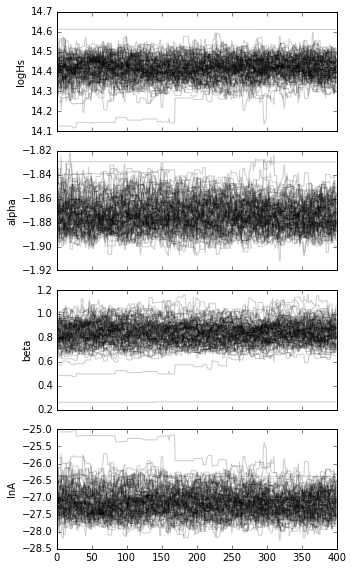

In [90]:
fig,ax = plt.subplots(4,1,sharex=True,figsize=(5,8))
for i,label in enumerate(['logHs','alpha','beta','lnA']):
    ax[i].plot(fitobj.mcmc_res.chain[:,:,i].T,color='k',alpha=0.2)
    ax[i].set_ylabel(label)
plt.tight_layout()

There doesn't seem to be much large-scale correlation here, so we remove these and use the chain as is (exact convergence criteria shouldn't make too much of a difference here). First calculate $\ln A_N$:

In [91]:
chain = {k:v for k,v in zip(['logHs','alpha','beta','lnA'],fitobj.mcmc_res.flatchain.T)}
lnAN = np.log(5e4) - np.log(10**chain['logHs']) - np.log(gammainc((chain['alpha']+1)/chain['beta'],(1e12/10**chain['logHs'])**chain['beta']))

The first thing we'll do with our data is plot a scatterplot of them against each other to show how correlated they are, and also show a histogram of each of them, to get an idea for how much information we are losing about the distribution by using $A_N$:

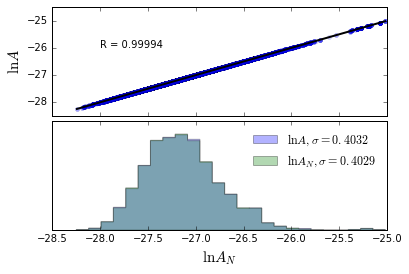

In [105]:
fig,ax=plt.subplots(2,1,sharex=True,gridspec_kw={"hspace":0.05})
ax[0].scatter(lnAN,chain['lnA'],lw=0.1,alpha=0.2)
x = np.linspace(lnAN.min(),lnAN.max(),100)
ax[0].plot(x,x,color='k',lw=2)
c,e,p = ax[1].hist(chain['lnA'],histtype='stepfilled',alpha=0.3,bins=25,label=r'$\ln A, \sigma = %.4f$'%np.std(chain['lnA']))
ax[1].hist(lnAN,alpha=0.3,histtype="stepfilled",bins=e,label=r"$\ln A_N, \sigma = %.4f$"%np.std(lnAN))
ax[1].yaxis.set_major_locator(plt.NullLocator())
ax[0].yaxis.set_major_locator(plt.MaxNLocator(5))

ax[0].set_ylabel(r"$\ln A$",fontsize=15)
ax[1].set_xlabel(r"$\ln A_N$",fontsize=15)
ax[1].legend(loc=0,frameon=False)
ax[0].text(-28,-26,r"R = %.5f"%pearsonr(chain['lnA'],lnAN)[0])
plt.show()

Clearly, the two are *very* correlated, and we are not losing almost any information by using $A_N$, and in fact this will likely help significantly with probing the posterior. Finally, we can look at the "residuals", i.e. the distribution of $\ln A - \ln A_N$, to see how tight it is:

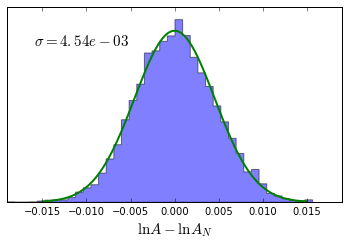

In [101]:
plt.figure(figsize=(6,3.5))
plt.hist(chain['lnA']-lnAN,bins=40,histtype='stepfilled',alpha=0.5,normed=True)
x = np.linspace(-0.015,0.015,100)
plt.plot(x,norm.pdf(x,scale=np.std(chain['lnA'] - lnAN)),lw=2)
plt.xlim((-0.019,0.019))
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.xlabel(r'$\ln A - \ln A_N$',fontsize=15)
plt.text(-0.016,80,r"$\sigma=%1.2e$"%np.std(chain['lnA'] - lnAN),fontsize=15)
plt.savefig("/home/steven/Documents/Projects/MRP/mrpArticle/figures/lnA-lnAN.pdf")
plt.show()